# Designing Selective Kinase Inhibitors Project

In this project, our aim is to predict pKi values of measured activity between molecules and kinase family of proteins. For building my deep learning models, I utilize Pytorch Geometric to represent the data as graphs and use Graph Neural Network (GNN) models to learn representation of the entities and predict pKi values.

In [1]:
# import libraries
import sklearn
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdkit
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T
import torch_geometric.utils as utils
from torch_geometric.data import Data
import scipy.sparse as sp
from torch_geometric.nn import GCNConv, global_mean_pool, avg_pool, SAGEConv
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# EDA

## Data Distribution

In [2]:
df = pd.read_csv('./kinase_JAK.csv')

In [3]:
print("Total number unique compunds(SMILES):", len(df["SMILES"].unique()))
print("Total pIC50 measurements:", df[df['measurement_type'] == 'pIC50'].shape[0])
print("Total pKi measurements:", df[df['measurement_type'] == 'pKi'].shape[0])

Total number unique compunds(SMILES): 4528
Total pIC50 measurements: 8736
Total pKi measurements: 1989


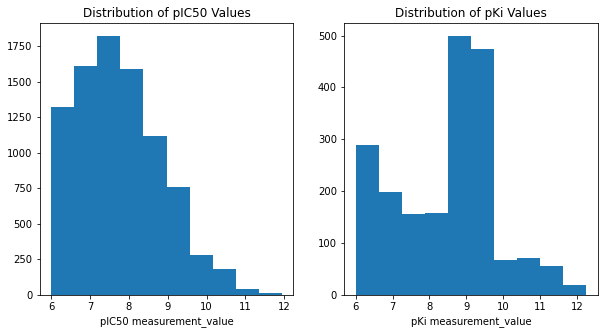

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ic50 = df[df['measurement_type'] == 'pIC50']
ax1.hist(ic50['measurement_value'])
ax1.set_title('Distribution of pIC50 Values')
ax1.set_xlabel('pIC50 measurement_value')

pki = df[df['measurement_type'] == 'pKi']
ax2.hist(pki['measurement_value'])
ax2.set_title('Distribution of pKi Values')
ax2.set_xlabel('pKi measurement_value')
plt.show()

In [5]:
smiles = list(df["SMILES"].unique())
unique_atoms = []

for i in smiles:
    mol = rdkit.Chem.MolFromSmiles(i)
    mol = rdkit.Chem.AddHs(mol)
    for atom in mol.GetAtoms():
        if atom.GetSymbol() not in unique_atoms:
            unique_atoms.append(atom.GetSymbol())
            
print("Unique Atoms in dataset:", unique_atoms)

Unique Atoms in dataset: ['C', 'O', 'N', 'F', 'H', 'Cl', 'S', 'Br', 'P', 'Si', 'I']


This dataset contains measured activity between molecules and kinases. In this dataset, there are two types measurement provided pIC50 and pKi. Molecules are represented in SMILES format, a chemical representation to represent moleculer structure in a linear format. One assumption I make is filtering dataset by pKi measurement values as that is our goal to predict.

# GNN Implementation 1

My first implementation idea to predict pKi measurement values was by developing a model that exploits the Molecule-Kinase interaction graph. In this implementation, we take a more global level approach of Molecule-Kinase interaction data and train the model to learn such interactions between molecules and kinases and eventually predict pKi values. This implementation follows a recommender system style approach where we have a bipartite graph of two entities and we set up a edge regression problem and try to predict values of links between entities.

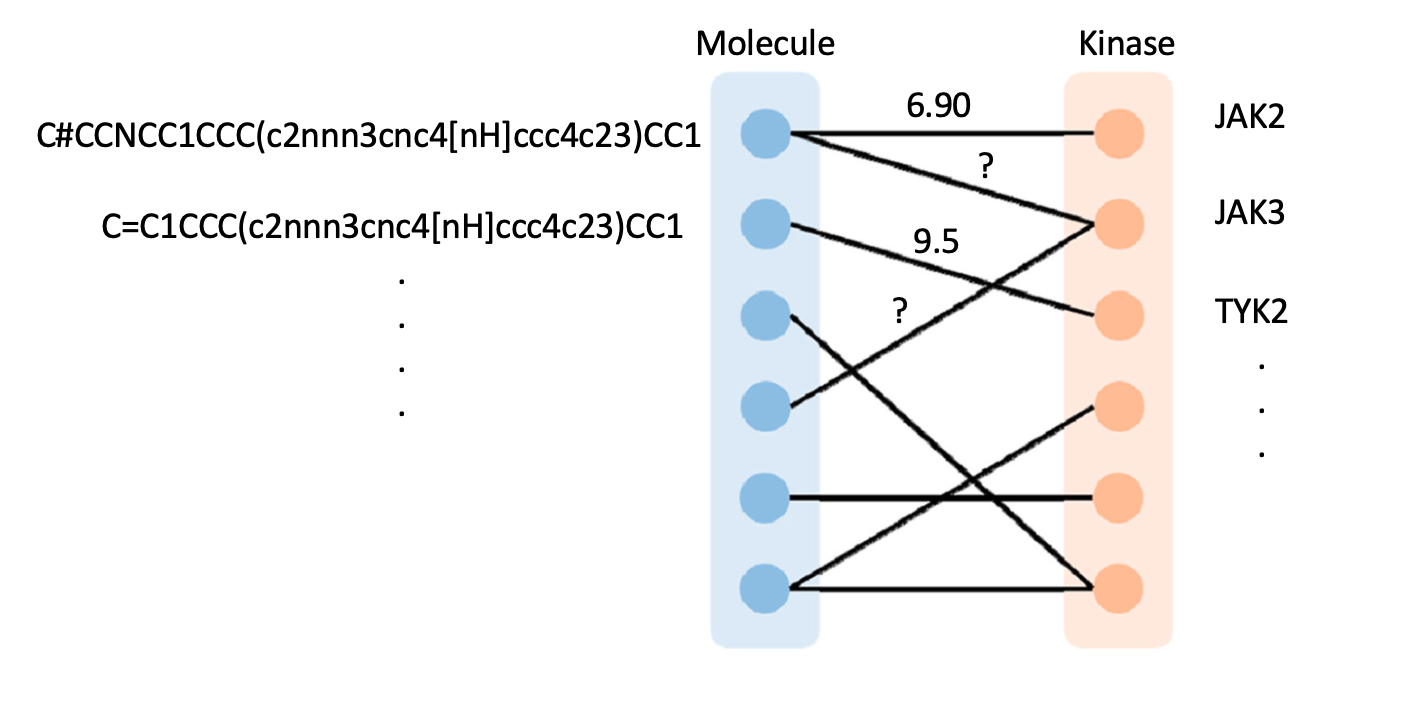

### 1. Data Preprocessing

To set up a bipartite network, the following steps are taken:
1. We first label encode all unique SMILES and Kinases and assign them with unique ids as PyTorch Geometric (PyG) requires node ids to start from 0 - num_nodes - 1.
2. Once we have the nodes, we create edges (Adjacency list) between molecules and kinases given from our dataset. PyG follows a sparse representation format for edges that is of shape (2, num_edges). For this setting, the bipartite graph is undirected.
3. Besides creating the Adjacency matrix representation, we also provide a feature matrix for nodes and since our goal for this task is to exploit the interaction between entities, I used an identity matrix in sparse representation format as input to the PyG dataset format.
4. Finally, a PyG data object is created where we can pass inputs features, adjacency list and target values.
5. Train and validation mask is also added to the PyG data object where model is trained on the trained and evaluated on the validation set.

In [6]:
# filter data based on pKi values
df_pki = df.copy()
df_pki = df_pki[df_pki['measurement_type'] == "pKi"].reset_index()


# initialize label encoder and fit on the dataset
le=preprocessing.LabelEncoder()
le.fit(np.concatenate((df_pki['SMILES'], df_pki['Kinase_name'])))

# renaming columns 
df_pki = df_pki.rename({'SMILES':'concept_id_1', 'Kinase_name':'concept_id_2'}, axis = 1)
df_pki['concept_id_1'] = le.transform(df_pki['concept_id_1'])
df_pki['concept_id_2'] = le.transform(df_pki['concept_id_2'])

# create edge matrix
edge_1 = torch.tensor(df_pki[['concept_id_1', 'concept_id_2']].values, dtype=torch.long)
edge_2 = torch.tensor(df_pki[['concept_id_2', 'concept_id_1']].values, dtype=torch.long)
edge = torch.cat((edge_1, edge_2), 0)

# pKi measurement values
measurement = torch.tensor(df_pki['measurement_value'].values, dtype=torch.float)

measurement_undirected = torch.cat((measurement, measurement), 0)

# creating train and validation masks 
indices = torch.arange(edge.t().contiguous().shape[1])
train_idx, val_idx = train_test_split(indices, test_size=0.3)
train_mask, val_mask = torch.zeros_like(indices).bool(), torch.zeros_like(indices).bool()
train_mask[train_idx] = 1
val_mask[val_idx] = 1

# create PyG data object
data = Data(edge_index=edge.t().contiguous(), train_mask=train_mask, val_mask=val_mask)

# create identity sparse representation as features for nodes
x = torch.sparse.FloatTensor(
        indices=torch.stack([torch.arange(data.num_nodes), torch.arange(data.num_nodes)]),
        values=torch.ones(data.num_nodes),
    )
data.x = x
data.__setitem__('measurement_value', measurement_undirected)


### 2. GNN Model Creation

The GNN model is created as follows:
1. An encoder class (GNN_Encoder) is created that uses Graph Convolution Networks (GCN) layers to learn representation of entities.
2. The second class (EdgeReg) takes as input the embeddings learned from the GCN layers. The embeddings from the connected nodes are concatenated together and passed through linear layers that return the final predicted measurement value.
3. The two classes are compiled together in one final class: Model.

In [7]:
class GNN_Encoder(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)
    
class EdgeReg(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.lin1 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, emb, edge_index):
        
        src, dst = edge_index
        emb_cat  = torch.cat([emb[src], emb[dst]], dim = -1)
        
        z = F.relu(self.lin1(emb_cat))
        z = self.lin2(z).view(-1)
        return z
        
class Model(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.encode = GNN_Encoder(in_dim, hidden_dim, hidden_dim)
        self.decode = EdgeReg(hidden_dim)
        
    def forward(x, edge_index):
        z = self.encode(x, edge_index)
        out = self.decode(z, edge_index)
        return out       

### 3. Model Training and Evaluation

Training and evaluation is done as follows:
1. The model is initialized with embedding dimension set to 128.
2. The loss function is set to be the Mean Squared Error loss as we predict real valued measurements. The optimizer is Adam and learning rate set to 0.01.
3. The data is split to train and val sets. The model is trained on the train set and to evaluate the model on the val set, the node embedding is first computed using the training set edges and then the prediction is tested against the validation set. 

In [8]:
# model, optimizer and loss function initialization
model = Model(data.num_features, 128)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

train_loss_lst = []
val_loss_lst = []

for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    
#     get train edges and measurements
    train_edge_index = data.edge_index[:, data.train_mask]
    train_edge_measurement = data.measurement_value[data.train_mask]
    
#     encode nodes
    z = model.encode(data.x, train_edge_index)
#     predict output 
    out = model.decode(z,  train_edge_index)
    loss = loss_fn(out,  train_edge_measurement)
    train_loss_lst.append(loss.item())
    loss.backward()
    optimizer.step()

# model evaluation    
    val_edge_index = data.edge_index[:, data.val_mask]
    val_edge_measurement = data.measurement_value[data.val_mask]

    with torch.no_grad():
        z = model.encode(data.x, train_edge_index)
        validation_out = model.decode(z, val_edge_index)
        validation_loss = loss_fn(validation_out, val_edge_measurement) 
        val_loss_lst.append(validation_loss.item())
    
    print("Epoch: {:03d}, Training loss: {:.4f}, Validation loss: {:.4f}".format(epoch + 1, loss, validation_loss))
            

Epoch: 001, Training loss: 74.0161, Validation loss: 60.6183
Epoch: 002, Training loss: 61.4652, Validation loss: 18.7914
Epoch: 003, Training loss: 19.5557, Validation loss: 37.7828
Epoch: 004, Training loss: 37.1978, Validation loss: 4.0672
Epoch: 005, Training loss: 4.2639, Validation loss: 10.9912
Epoch: 006, Training loss: 11.5879, Validation loss: 18.2590
Epoch: 007, Training loss: 18.9355, Validation loss: 15.7475
Epoch: 008, Training loss: 16.3821, Validation loss: 7.9346
Epoch: 009, Training loss: 8.4027, Validation loss: 2.2869
Epoch: 010, Training loss: 2.3801, Validation loss: 6.3828
Epoch: 011, Training loss: 5.8943, Validation loss: 10.5413
Epoch: 012, Training loss: 9.7645, Validation loss: 4.9814
Epoch: 013, Training loss: 4.5037, Validation loss: 1.8981
Epoch: 014, Training loss: 1.8885, Validation loss: 4.0174
Epoch: 015, Training loss: 4.3233, Validation loss: 6.0804
Epoch: 016, Training loss: 6.5141, Validation loss: 5.4083
Epoch: 017, Training loss: 5.8187, Validat

Epoch: 140, Training loss: 1.3964, Validation loss: 1.3345
Epoch: 141, Training loss: 1.3941, Validation loss: 1.3331
Epoch: 142, Training loss: 1.3919, Validation loss: 1.3309
Epoch: 143, Training loss: 1.3896, Validation loss: 1.3282
Epoch: 144, Training loss: 1.3873, Validation loss: 1.3259
Epoch: 145, Training loss: 1.3850, Validation loss: 1.3242
Epoch: 146, Training loss: 1.3827, Validation loss: 1.3231
Epoch: 147, Training loss: 1.3804, Validation loss: 1.3217
Epoch: 148, Training loss: 1.3780, Validation loss: 1.3197
Epoch: 149, Training loss: 1.3757, Validation loss: 1.3173
Epoch: 150, Training loss: 1.3733, Validation loss: 1.3150
Epoch: 151, Training loss: 1.3709, Validation loss: 1.3132
Epoch: 152, Training loss: 1.3686, Validation loss: 1.3117
Epoch: 153, Training loss: 1.3662, Validation loss: 1.3103
Epoch: 154, Training loss: 1.3638, Validation loss: 1.3084
Epoch: 155, Training loss: 1.3613, Validation loss: 1.3062
Epoch: 156, Training loss: 1.3589, Validation loss: 1.30

Epoch: 281, Training loss: 0.7939, Validation loss: 0.9571
Epoch: 282, Training loss: 0.7811, Validation loss: 0.9528
Epoch: 283, Training loss: 0.7680, Validation loss: 0.9485
Epoch: 284, Training loss: 0.7546, Validation loss: 0.9445
Epoch: 285, Training loss: 0.7409, Validation loss: 0.9408
Epoch: 286, Training loss: 0.7268, Validation loss: 0.9372
Epoch: 287, Training loss: 0.7125, Validation loss: 0.9339
Epoch: 288, Training loss: 0.6978, Validation loss: 0.9307
Epoch: 289, Training loss: 0.6829, Validation loss: 0.9276
Epoch: 290, Training loss: 0.6678, Validation loss: 0.9248
Epoch: 291, Training loss: 0.6525, Validation loss: 0.9224
Epoch: 292, Training loss: 0.6370, Validation loss: 0.9204
Epoch: 293, Training loss: 0.6214, Validation loss: 0.9183
Epoch: 294, Training loss: 0.6056, Validation loss: 0.9160
Epoch: 295, Training loss: 0.5898, Validation loss: 0.9133
Epoch: 296, Training loss: 0.5740, Validation loss: 0.9102
Epoch: 297, Training loss: 0.5583, Validation loss: 0.90

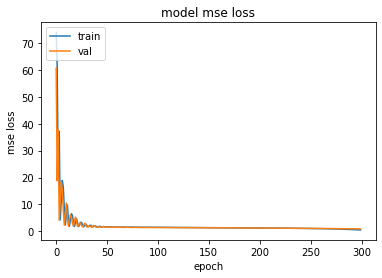

In [9]:
plt.plot(range(len(train_loss_lst)), train_loss_lst)
plt.plot(range(len(val_loss_lst)), val_loss_lst)
plt.title('model mse loss')
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 4. Summary

In this implementation, we aim to learn the interactions between molecules and kinases by taking a more global level approach. Although, this model only uses identity matrix as input to the nodes but we can further improve the by including features for molecules and kinases such as pre-trained embeddings or any other additional features. 

# GNN Implementation 2

In this implementation, the goal was to train a model that utilizes the structure of molecules by creating a graph for each molecule using atoms as nodes and bonds between atoms as edges. For each molecular graph we learn their embeddings and combine them with the vector representation of the kinase they interact with to finally predict the pKi measurement value.

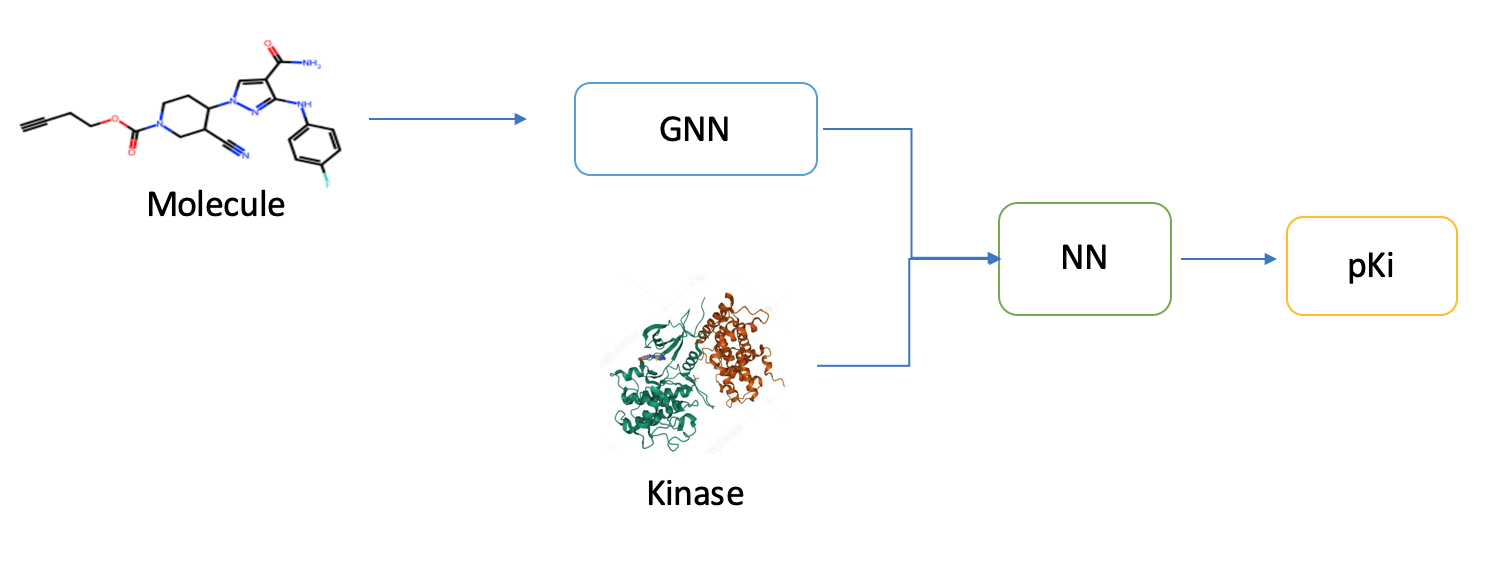

### 1. Data Preprocessing

The data preprocessing for this model is done as follows:
1. We first create a one-hot vector representation of the 4 Kinases.
2. To create a molecular graph, we first convert the smiles coding to rdkit's molecule format. We can then utilize rdkit's functions to generate the adjacency matrix between atoms and also add features for atoms in the molecule. I learned there can multiple types of features that can be included and in this case I utilize 3 features: Atomic Number, Total Degree and Aromatic (Binary) to test out the model.
3. After creating the feature and adjacency representation of nodes, we can create a PyG data object and also add the vector representation of the kinase associated with the molecule along with the measurement value.
4. Finally, we create a Pytorch dataloader object of all molecules and split the dataloaders into train-val format.

In [19]:
def create_molecule_graph(smile, kinase_name, measurement_value, kinase_dict):
    
    '''
    Returns a PyG data object of molecules along with kinase vector representation and measurement value.

            Args:
                    smile (str): A Smiles encoding of Molecules
                    kinase_name (str): Name of the kinase associated with the molecule
                    measurement_value (float): pKi measurement value.
                    kinase_dict (dict): Dictionary containing vector representation of the kinase

            Returns:
                    data (PyG Data Object): PyG Data object of molecules and kinases.
    '''
    
#     create adjacency matrix of molecules.
    molecule = rdkit.Chem.MolFromSmiles(smile)
    # molecule = rdkit.Chem.AddHs(molecule)
    src, dst = np.nonzero(GetAdjacencyMatrix(molecule))
    src = torch.from_numpy(src).to(torch.long)
    dst = torch.from_numpy(dst).to(torch.long)
    edges = torch.stack([src, dst], dim = 0)

#     create features for atoms
    x = []
    for atom in molecule.GetAtoms():
        atom_lst = []
        atom_lst.append(atom.GetAtomicNum())
        atom_lst.append(atom.GetTotalDegree())
        atom_lst.append(int(atom.GetIsAromatic()))
        x.append(atom_lst)
    x = torch.tensor(x, dtype=torch.float)

#     create data object of molecules
    data = Data(x=x, edge_index = edges)
    data.num_nodes = x.shape[0]
    data.__setitem__('smiles',smile)
    data.__setitem__('kinase_name',kinase_name)
    data.__setitem__('kinase_vec', torch.tensor(kinase_dict[kinase_name], dtype = torch.float).view(-1,1))
    data.y =  torch.tensor(measurement_value, dtype= torch.float)
    return data



# create one-hot vector representation of kinases
lst = ['JAK2', 'JAK1', 'JAK3', 'TYK2']
matrix = np.eye(4)
kinase_dict = {}
for index, kinase in enumerate(lst):
    kinase_dict[kinase] = matrix[index]
    
    
# create Pytorch dataloader for a all molecules of batch-size set to 32
pyg_data_lst = []
for index, row in df.iterrows():
    smiles = row.SMILES
    kinase = row.Kinase_name
    measurement = row.measurement_value
    data_object = create_molecule_graph(smiles, kinase, measurement, kinase_dict)
    pyg_data_lst.append(data_object)


# creating train and val dataloaders
train_split, val_split = train_test_split(pyg_data_lst, test_size=0.30)
train_loader = DataLoader(train_split, batch_size = 32)
val_loader = DataLoader(val_split, batch_size = 32)

## 2. GNN Model

The GNN model is created as follows:
1. Two layers of GCN are initialized that create a representation of nodes in the molecules. Because GCN create node-specific embeddings and since we are working with graphs, therefore, a global mean pooling layer is added to create a final representation of the graphs.
2. After creating the representation of graphs, the vector representation of kinases is concatenated with representation of graphs and passed through MLP layers to finally predict the pKi measurment values.

In [16]:
class GNN_New(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim = 1, kinase_dim=4):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.mean_pool = global_mean_pool 
        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim + kinase_dim, out_dim)
        
    
    def forward(self, data, data_len):
        
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        x = self.mean_pool(x, data.batch)
        
        x = F.relu(self.lin1(x))
        kinase_vec = data.kinase_vec.view(data_len, -1)
        x_concat = torch.cat((x, kinase_vec), -1)
        out = self.lin2(x_concat)
        
        return out

### 3. Model Training and Evaluation

Training and evaluation is done as follows:
1. The model is initialized with embedding dimension set to 128.
2. The loss function is set to be the Mean Squared Error loss as we predict real valued measurements. The optimizer is Adam and learning rate set to 0.01.
3. The data is split to train and val sets. The model is trained on the train set and to evaluate the model on the val set, the node embedding is first computed using the training set edges and then the prediction is tested against the validation set. 

In [20]:
model = GNN_New(3,128) 
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device(cuda_name if torch.cuda.is_available() else "cpu")

train_loss_lst = []
val_loss_lst = []
for epoch in range(30):
    
    model.train()
    avg_loss_train = 0
    avg_loss_val = 0
    
    for id, data in enumerate(train_loader):
        data = data.to(device)
        data_len = len(data)
        optimizer.zero_grad()
        output = model(data, data_len)
        loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        avg_loss_train += loss.item()
   
    train_loss_per_batch = avg_loss_train/len(train_loader)
    train_loss_lst.append(train_loss_per_batch)    
       
    with torch.no_grad():
        for id, val_data in enumerate(val_loader):
            val_data = val_data.to(device)
            val_data_len = len(val_data)
            output = model(val_data, val_data_len)
            val_loss = loss_fn(output, val_data.y.view(-1, 1).float().to(device))
            avg_loss_val += val_loss.item()
    
    val_loss_per_batch = avg_loss_val/len(val_loader)
    val_loss_lst.append(avg_loss_val/len(val_loader))
    
    print("Epoch: {:03d}, Training loss: {:.4f}, Validation loss: {:.4f}".format(epoch + 1, train_loss_per_batch, val_loss_per_batch))


Epoch: 001, Training loss: 2.4075, Validation loss: 1.3360
Epoch: 002, Training loss: 1.2892, Validation loss: 1.1658
Epoch: 003, Training loss: 1.3184, Validation loss: 1.1573
Epoch: 004, Training loss: 1.3062, Validation loss: 1.2102
Epoch: 005, Training loss: 1.2805, Validation loss: 1.2576
Epoch: 006, Training loss: 1.2537, Validation loss: 1.2531
Epoch: 007, Training loss: 1.2342, Validation loss: 1.2263
Epoch: 008, Training loss: 1.2159, Validation loss: 1.1941
Epoch: 009, Training loss: 1.2041, Validation loss: 1.1646
Epoch: 010, Training loss: 1.1976, Validation loss: 1.1438
Epoch: 011, Training loss: 1.2045, Validation loss: 1.1436
Epoch: 012, Training loss: 1.1986, Validation loss: 1.1666
Epoch: 013, Training loss: 1.1941, Validation loss: 1.1742
Epoch: 014, Training loss: 1.1801, Validation loss: 1.1454
Epoch: 015, Training loss: 1.1718, Validation loss: 1.1652
Epoch: 016, Training loss: 1.1666, Validation loss: 1.1767
Epoch: 017, Training loss: 1.1626, Validation loss: 1.18

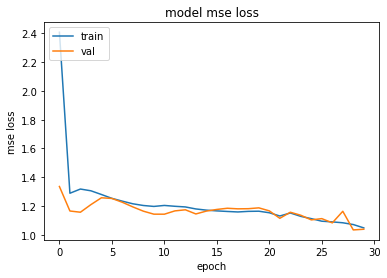

In [21]:
plt.plot(range(len(train_loss_lst)), train_loss_lst)
plt.plot(range(len(val_loss_lst)), val_loss_lst)
plt.title('model mse loss')
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 4. Summary

In this implementation, we aim to learn representation of molecular graphs and combine the embeddings with the one-hot vector representation of kinases to predict the pKi measurement values. From the plots above we test to see the model performance of train and validation sets. Although we notice the model overfits on the train but it can be adjusted with hyperparameter tuning and regularization. We can also include more features for atoms and explicitly include hydrogen atoms as well as include multiple edge types such as different bonds between atoms and in that case we can use a Relational GNN approach to explot the multiple edge types. Additionally, I feel we can improve the model further by learning a representation of Kinases and include features as well, as opposed to including a basic one-hot vector representation of kinases.

# Model Deployment

One of the simpler ideas for model deployment would be to save the model and its parameters as an object such as in a  pickle format. We could set up a basic web appilcation and set up a pipepline that does the preprocessing part and creates a PyG data object from the input and then uses the model object to make predcitions. To build on top of this basic framework we can set up a pipeline that takes input from multiple sources to create more robust representation of input by including additional features then stores the data object format into data warehouse. As more data comes in one thing to keep in mind the idea the distributional shift of the data. To make sure such factors are taken into account, we must develop a cycle take can retrain the model and update the parameters to make the model more generalizable. 

# Future Ideas

As mentioned above, we can further improve our models by including more features for our input data either on a atomic level or global level. Additionally, we can include features for our kinases proteins as well. To include additional robust representations we can use sequence models such as tranformers on the input smiles codes or kinases protein codes or include more advanced GNN models comapared to GCN as they suffer from learning on large networks.